In [1]:
import os
os.chdir('/lustre/scratch/kiviaho/prostate_spatial')

import numpy as np
import anndata as ad
import scanpy as sc
import pandas as pd
import anndata as ad
import seaborn as sns

import matplotlib.pyplot as plt
from pathlib import Path
from scripts.utils import load_from_pickle, save_to_pickle

import warnings
warnings.filterwarnings('ignore')
sc.set_figure_params(figsize=(6,6),dpi=120)


## Scoring intagrated single cell data sets

### Define markers to define cell types

In [2]:
refined_markers = {'Epithelial':['KRT5','KRT7','KRT19','MMP7','EPCAM','PRAC1','HOXB13','LRRC26','SPDEF','NKX3-1',
                                 'KLK3','FOLH1','SCHLAP1','PLA2G2A','MSMB','CETN2','ZMYND10','EPCAM','PCA3','KLK3',
                                 'KRT18','KRT8','ACPP','MSMB','S100P','SCGB3A1','SCGB1A1','SLC4A4','CLDN3','SAA1',
                                 'SAA2','KRT17','S100A2','ACPP','KLK3','MSMB','KLK2','NEFH','AZGP1','RDH11','PLA2G2A',
                                 'TMPRSS2','NKX3-1','AR','KRT19','KRT18','KRT8','TP63','KRT14','KRT5','DPP4'],
                    'Endothelial':['ACKR1','CCL14','PECAM1','IFI27','CLEC14A','ENPP2','DEPP1','RAMP2','VWF',
                                   'IF127','RNASE1','ACKR1','TM4SF1','VWF','SELE','IFI27','FLT1','SPARCL1',
                                   'SDPR','PTPRB','DARC','PLVAP','A2M','PECAM1','VWF','ENG'],
                    'Fibroblast':['LUM','DCN','IGF1','DCN','LUM','MGP','DCN','PTGDS','APOD',
                                  'STC1','AREG','DCN','FBLN1','COL1A2','IGF1','C7','IGFBP5','CCDC80','CFD','LTBP4','SFRP1','ACTA2'],
                    'SMC':['RGS5','ACTA2','TAGLN','BGN','RGS5','MT1M','ACTA2','ACTG2','DES','RGS5','NDUFA4L2','RERGL','MYH11','RGS5',
                           'ACTA2','TAGLN','MYL9','MYLK','C11orf96','MCAM','CALD1','LMOD1'],
                    'Mast':['KIT','TPSB2','TPSAB1','CPA3','TPSAB1','CPA3','CPA3','TPSAB1','KIT',
                            'VWA5A','IL1RL1','CTSG','SLC18A2','ACSL4','MS4A2','GATA2','CMA1','MS4A2','TPSAB1','TPSB2'],
                    'T cell':['CD3D','CD3E','CD3G','CD8A','CD8B','IL7R','CD2','CCL5','IFNG','CD8B','CD8A','SMC4','MK167',
                              'CTLA4','IL2RA','FOXP3','CD3D','CCL5','CD69','IL7R','TRBC2','CCL5','IFNG','CD8A','CXCR4',
                              'PTPRC','ETS1','CCL4','CD69','PDCD1','CTLA4','CD8A','SELL','PTPRC','BTLA','IL2RA','IL7R',
                              'CCR7','CD28','CD27','SLAMF1','CD7','CD2','CD3G','CD3E','CD3D'],
                        'B cell':['CD79A','MS4A1','MS4A1','CD79B','IGJ','TPSB2',
                                  'TPSAB1','IGKC','IGHA1','IGHA2','AC096579.7','MZB1',
                                  'IGHG3','SLAMF7','IGHG4','IGHG1','MS4A1','IGHM','CXCR5','CD79A','CD22','BANK1','LY9','CCR7','IRF8','CD83'],
                        'Myeloid':['CD4','C1QA','C1QB','AIF1','CD68','LYZ','IL1B','FCN1','S100A12','C1QC','C1QA','S100A9','S100A8','LYZ',
                                   'HLA-DPB1','HLA-DRA','IL1B','HLA-DRA','HLA-DPA1','HLA-DPB1','HLA-DRB1','CD74','IL8','HLA-DQA1','IF130',
                                   'LYZ','FCGR3A','CSF1R','CD68','CD163','CD14','UCHL1','HAVCR2','CD4'],
                        'Neuronal':['PLP1','MPZ','S100A8','MT1H'],
                        'Dendritic':['IRF7','IRF4','FCER1A','CD1C'],
                        'Plasma':['IGJ','XBP1','MZB1']
                                 }

# Modify the list of markers to 
# 1) be sorted according to the number of publications a marker is present in
# 2) not contain any duplicates
for k in refined_markers.keys():
    refined_markers[k] = list(pd.Series(refined_markers[k]).value_counts().index)


In [3]:
# Save the marker genes as an excel file

max_length = max([len(refined_markers[k]) for k in refined_markers])

# Pad each Series with NaN values to match the maximum length
markers_dict_padded = {}
for k in refined_markers:
    s = pd.Series(refined_markers[k].copy())
    markers_dict_padded[k] = s.fillna(max_length)

pd.DataFrame(markers_dict_padded).to_excel('./supplementary_tables/marker_genes_used_in_single_cell_annotation.xlsx')

In [9]:
def drop_missing_markers(marker_list,missing_vals):
    for v in marker_list.values():
        for miss in missing_vals:
            if (miss) in v:
                v.remove((miss))
    return marker_list

### Download the dataset and plot integration results

In [28]:
adata = load_from_pickle('./scvi_integrated_7_sc_datasets_20230613.pickle')
original_phenotype_counts = adata.obs['phenotype'].value_counts()
adata

AnnData object with n_obs × n_vars = 327771 × 2000
    obs: 'sample', 'patient', 'celltype_orig', 'phenotype', 'dataset', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'n_genes', 'doublet_score', 'predicted_doublet', 'size_factors', 'clusters', 'broad_celltypes', '_scvi_batch', '_scvi_labels', 'VI_clusters'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg', '_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'umap', 'leiden'
    obsm: 'X_scVI', 'X_umap'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

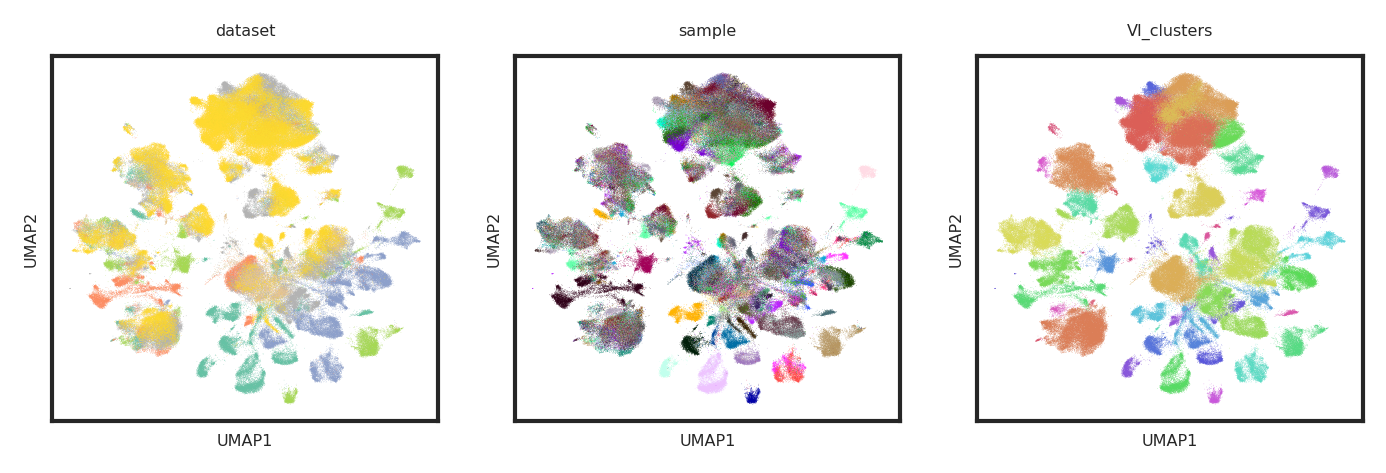

In [19]:
#sc.set_figure_params(figsize=(6,6),dpi=120)
sns.set_theme(style='white',font_scale=0.4)
spot_size = 0.1
pal = sns.color_palette('hls',len(adata.obs['VI_clusters'].unique()))

fig,axs = plt.subplots(1,3,figsize=(7,2))
sc.pl.umap(adata,color='dataset', s=spot_size,palette='Set2',ax=axs[0],show=False,legend_loc=None)
sc.pl.umap(adata,color='sample', s=spot_size,ax=axs[1],show=False,legend_loc=None)
sc.pl.umap(adata,color='VI_clusters', s=spot_size,palette=pal,ax=axs[2],show=False,legend_loc=None)
plt.savefig('plots/sc-reference-integration-umaps/umap_with_dataset_sample_clusters.png',dpi=900)
plt.show()

## Remove clusters with sample bias

In [32]:
purity_thr = 0.8
orig_n_cells = len(adata)

to_be_dropped_by_sample_purity = list()

for clust in adata.obs['VI_clusters'].cat.categories:
    counts = adata[adata.obs['VI_clusters'] == clust].obs['sample'].value_counts()
    purity = counts[0]/counts.sum() # What proportion of the cluster is represent by the top sample
    if purity > purity_thr:
        print('Cluster '+ clust +' purity for sample ' + counts.index[0] + ': {0:.1%}'.format(purity))
        to_be_dropped_by_sample_purity.append(clust)

print('')
print('{:d} clusters dropped'.format(len(to_be_dropped_by_sample_purity)))

adata_dropped = adata[adata.obs['VI_clusters'].isin(to_be_dropped_by_sample_purity)].obs.copy()
adata = adata[~adata.obs['VI_clusters'].isin(to_be_dropped_by_sample_purity)]

# Calculate the difference between original data shape and the resulting data shape
print('{:d} cells discarded'.format(orig_n_cells-len(adata)))
adata

Cluster 17 purity for sample chen_12: 99.6%
Cluster 18 purity for sample chen2022_P1: 97.6%
Cluster 19 purity for sample GSM4711415_P6: 98.7%
Cluster 26 purity for sample chen_2: 98.4%
Cluster 29 purity for sample GSM4089151_P1: 99.8%
Cluster 30 purity for sample CRPC3_A: 98.8%
Cluster 31 purity for sample chen_8: 97.3%
Cluster 33 purity for sample chen_4: 93.2%
Cluster 34 purity for sample wong2022_HYW_4881_Tumor: 88.2%
Cluster 35 purity for sample GSM4711414_P5: 99.3%
Cluster 36 purity for sample chen_3: 99.3%
Cluster 38 purity for sample hirz_PCA10_T: 80.0%
Cluster 39 purity for sample GSM4089152_P2: 96.7%
Cluster 40 purity for sample GSM4089154_P4: 98.6%
Cluster 44 purity for sample chen_13: 99.4%
Cluster 45 purity for sample hirz_PCA11_T: 89.1%

16 clusters dropped
42817 cells discarded


View of AnnData object with n_obs × n_vars = 284954 × 2000
    obs: 'sample', 'patient', 'celltype_orig', 'phenotype', 'dataset', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'n_genes', 'doublet_score', 'predicted_doublet', 'size_factors', 'clusters', 'broad_celltypes', '_scvi_batch', '_scvi_labels', 'VI_clusters'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg', '_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'umap', 'leiden'
    obsm: 'X_scVI', 'X_umap'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [37]:
# This is the percentage of each sample category that was dropped.
dropped_phenotype_counts = adata_dropped['phenotype'].value_counts()
dropped_phenotype_counts / original_phenotype_counts.loc[dropped_phenotype_counts.index]

PCa       0.115851
CRPC      0.418426
normal    0.053463
Name: phenotype, dtype: float64

categories: 0, 1, 2, etc.
var_group_labels: Epithelial, Endothelial, Fibroblast, etc.


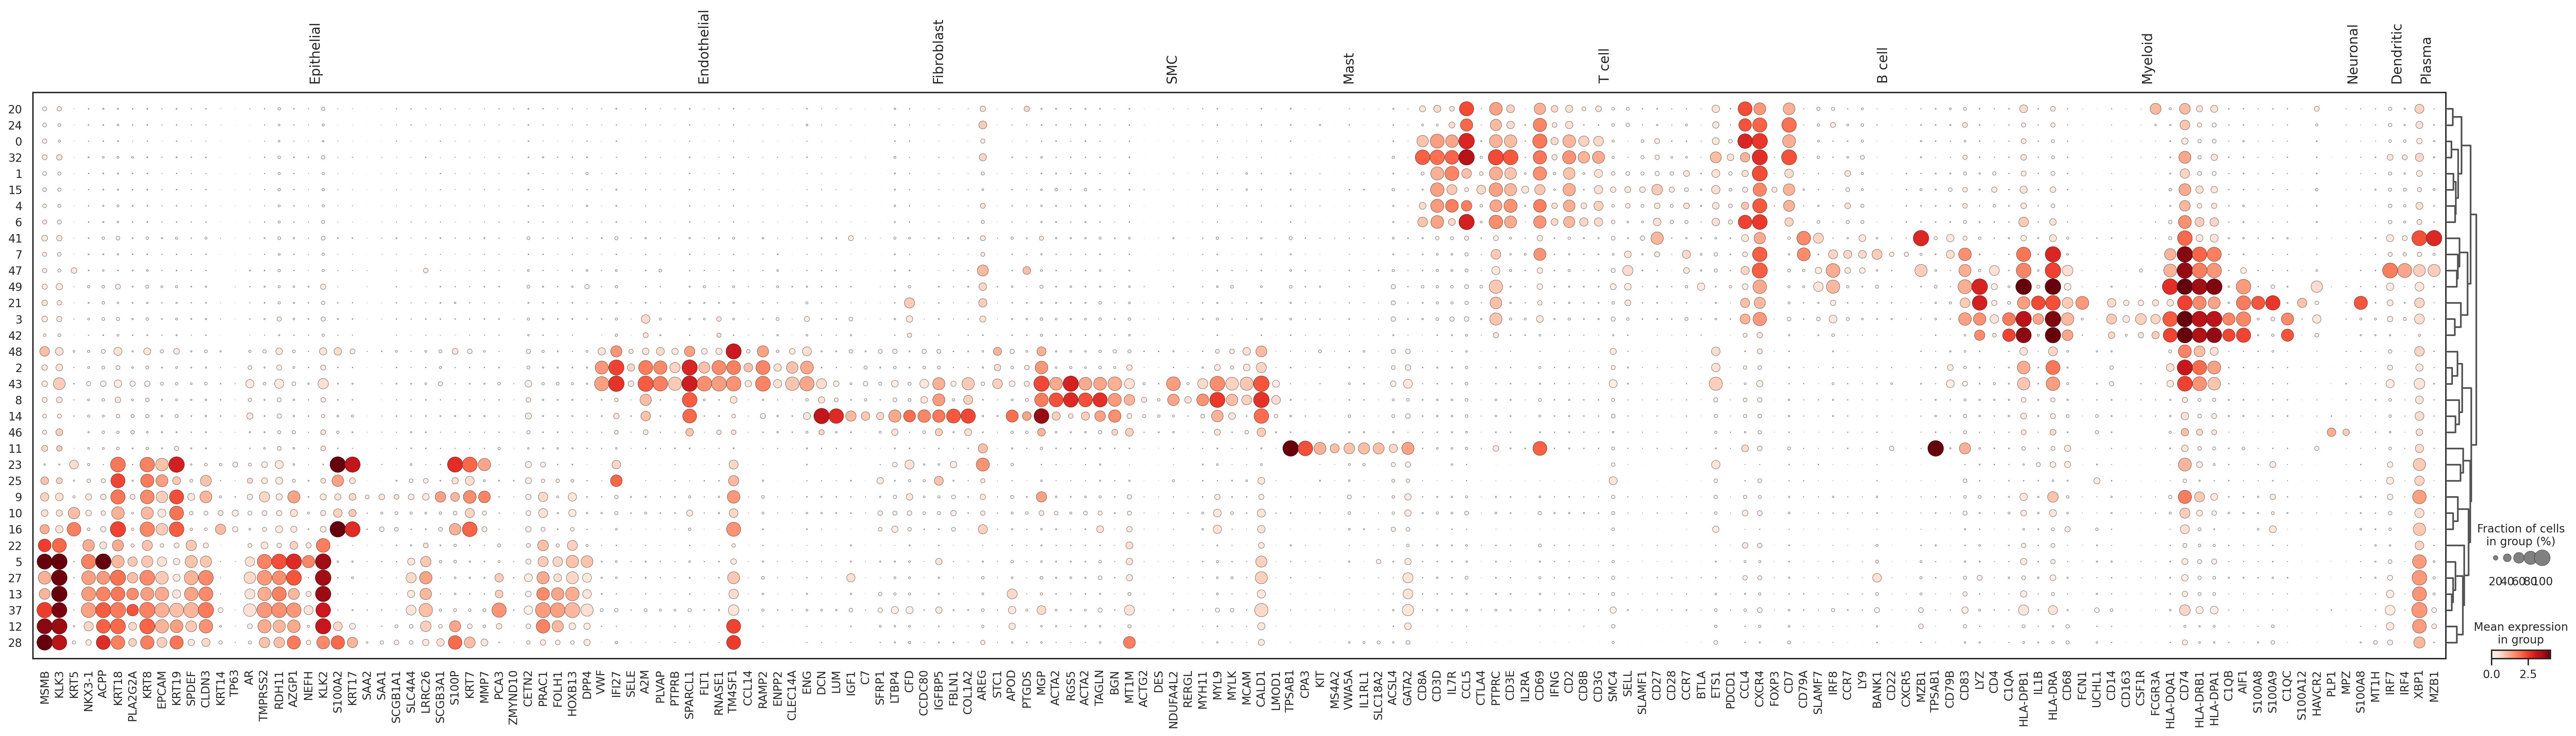

In [39]:
sns.set_theme(style='white',font_scale=1)
sc.tl.dendrogram(adata,groupby='VI_clusters',use_rep='X_scVI')
fig,ax = plt.subplots(figsize=(40,10))
sc.pl.dotplot(adata, refined_markers, groupby='VI_clusters', dendrogram=True, log= False,
              swap_axes = False, vmax=4,
              ax=ax,show=False,
              )
plt.show()

## Re-annotate clusters to find cell types

In [44]:
# Modify the labels according to the dotplot
broad_celltypes = adata.obs['VI_clusters'].copy()

broad_celltypes = broad_celltypes.replace(['28','12','37','13','27','5','22','16','10','9','25','23'],'Epithelial')
broad_celltypes = broad_celltypes.replace(['43','2','48'],'Endothelial')
broad_celltypes = broad_celltypes.replace(['8','14'],'Fibroblast_muscle')
broad_celltypes = broad_celltypes.replace(['11'],'Mast')
broad_celltypes = broad_celltypes.replace(['6','4','15','1','32','0','24','20'],'T cell')
broad_celltypes = broad_celltypes.replace(['7'],'B cell')
broad_celltypes = broad_celltypes.replace(['49','21','3','42'],'Myeloid') # ,'48','2','43'
broad_celltypes = broad_celltypes.replace(['41'],'Plasma')
broad_celltypes = broad_celltypes.replace(['47'],'Dendritic')
broad_celltypes = broad_celltypes.replace(['46'],'Neuronal')

adata.obs['refined_celltypes'] = broad_celltypes



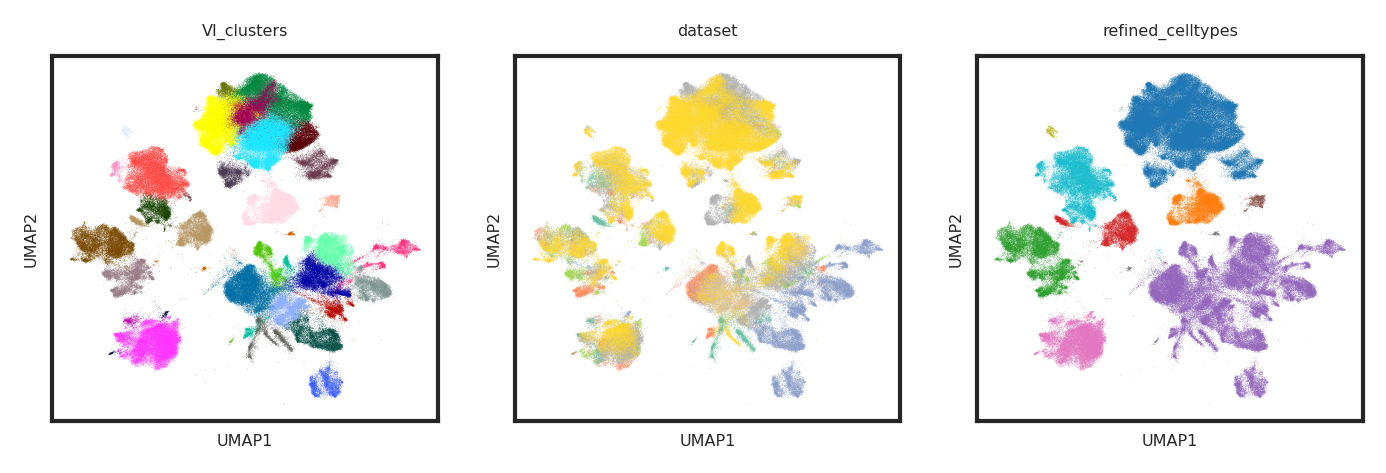

In [45]:
#sc.set_figure_params(figsize=(6,6),dpi=120)
sns.set_theme(style='white',font_scale=0.4)
spot_size = 0.1
pal = sns.color_palette('hls',len(adata.obs['VI_clusters'].unique()))

fig,axs = plt.subplots(1,3,figsize=(7,2))
sc.pl.umap(adata,color='VI_clusters', s=spot_size,ax=axs[0],show=False,legend_loc=None)
sc.pl.umap(adata,color='dataset', s=spot_size,palette='Set2',ax=axs[1],show=False,legend_loc=None)
sc.pl.umap(adata,color='refined_celltypes', s=spot_size,palette='tab10',ax=axs[2],show=False,legend_loc=None)

#plt.savefig('plots/sc-reference-integration-umaps/umap_with_filtered_dataset_sample_clusters.png',dpi=900)
plt.show()


In [53]:
for ctype in ['Epithelial','Fibroblast_muscle','Endothelial']:
    obs_data = adata.obs.copy()
    n_samples = (obs_data[obs_data['refined_celltypes']==ctype]['sample'].value_counts() >= 100).sum()
    print(ctype + ' number of samples: {:d}'.format(98-n_samples))

Epithelial number of samples: 12
Fibroblast_muscle number of samples: 52
Endothelial number of samples: 44


## Save annotated cells with raw gene counts

In [8]:
# Transfer the scVI embeddings and UMAP coorinates onto the full data.
# Load the pickle object and transfer all necessary info
# Note that the counts layer contains unscaled, unnormalized data.
whole_adata = load_from_pickle('./sc-reference/normalized_sc_7_datasets.pickle')

whole_adata = ad.concat(whole_adata,join='outer') # Changed this from inner to outer to stop relevant genes from being filtered out
whole_adata.obs_names_make_unique() # Some duplicate index persists

# Subset and annotate the whole data (with all the genes) by SCVI-integration
final_adata = whole_adata[adata.obs_names]

if (adata.obs.index == final_adata.obs.index).all():
    final_adata.obs = adata.obs.copy()
    final_adata.obsm = adata.obsm.copy()
    final_adata.obsp = adata.obsp.copy()
    final_adata.uns['hvg'] = list(adata.var_names)

# Drop redundant observation columns for a neat dataframe
final_adata.obs = final_adata.obs.drop(columns=['total_counts_mt','pct_counts_mt','n_genes_by_counts','doublet_score',
                      'predicted_doublet','size_factors','_scvi_batch','_scvi_labels'])

final_adata

AnnData object with n_obs × n_vars = 273534 × 37122
    obs: 'sample', 'patient', 'celltype_orig', 'phenotype', 'dataset', 'total_counts', 'n_counts', 'n_genes', 'chemistry_version', 'VI_clusters', 'refined_celltypes'
    uns: 'hvg'
    obsm: '_scvi_extra_categorical_covs', 'X_scVI', 'X_umap', 'X_pca'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [10]:

from datetime import datetime
current_date = datetime.today().strftime('%Y%m%d')
final_adata.write('aggregate_sc_data_with_broad_annotation_'+current_date+'.h5ad')


In [22]:
# Write these cell types their own anndata objects for nmf 
for ctype in ['Epithelial','Endothelial','Fibroblast_muscle']:
    subs = final_adata[final_adata.obs['refined_celltypes'] == ctype]
    sc.pp.filter_genes(subs,1) # Remove genes that have no information
    subs.write_h5ad('./nmf_annotation/'+ctype+'.h5ad')

In [23]:
# Write all immune cells into a single anndata for celltypist
immune_cells = ['T cell','Myeloid','B cell','Neuronal','Plasma','Mast','Dendritic']
immune_dat = final_adata[final_adata.obs['refined_celltypes'].isin(immune_cells)]
sc.pp.filter_genes(immune_dat,1) # Remove genes that have no information

# Prepare for celltypist
immune_dat.X = immune_dat.layers['counts'].copy()
sc.pp.normalize_total(immune_dat,target_sum=1e4)
sc.pp.log1p(immune_dat)
immune_dat.write('./celltypist/immune_cells_for_celltypist_'+current_date+'.h5ad')